## CSCI 656: Data Mining - Final Project

### Restaurant Visitor Forecasting

### Description

A restaurant visitors forecasting problem based on time series data. 

The objective is to predict restaurant visitor on a given date in future.

The data comes from two sites:

1. Hot Pepper Gourmet (hpg): here users can search restaurants and also make a reservation online
2. AirREGI / Restaurant Board (air): a reservation control and cash register system

The training data covers the dates from 2016 until April 2017. 
The test set covers the last week of April and May of 2017. 

Assumptions:
There are days in the test set where the restaurant were closed and had no visitors. 
The training set omits days where the restaurants were closed.

Data Source:
##### https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import datetime as dt

import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn.ensemble import AdaBoostRegressor

#### Loading Data

In [2]:
air_visit = pd.read_csv('./data/air_visit_data.csv', parse_dates=[1], infer_datetime_format=True)
air_res = pd.read_csv('./data/air_reserve.csv', parse_dates=[1 , 2], infer_datetime_format=True)
air_store = pd.read_csv('./data/air_store_info.csv')
hpg_res = pd.read_csv('./data/hpg_reserve.csv', parse_dates=[1 , 2], infer_datetime_format=True)
hpg_store = pd.read_csv('./data/hpg_store_info.csv')
store_id_rel = pd.read_csv('./data/store_id_relation.csv')
date_info = pd.read_csv('./data/date_info.csv', parse_dates=[0], infer_datetime_format=True).rename(columns={'calendar_date': 'visit_date'})
test_data = pd.read_csv('./data/sample_submission.csv')

#### EDA

This dataset includes the following files:

- air_visit_data.csv: historical visit data for the air restaurants.

- air_reserve.csv / hpg_reserve.csv: reservations made through the air / hpg systems.

- air_store_info.csv / hpg_store_info.csv: details about the air / hpg restaurants.

- store_id_relation.csv: relates the air and hpg ids.

- date_info.csv: List of Japanese holidays.

- sample_submission.csv: the test set.

In [3]:
air_visit.info()
air_visit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   air_store_id  252108 non-null  object        
 1   visit_date    252108 non-null  datetime64[ns]
 2   visitors      252108 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [4]:
air_visit.nunique()

air_store_id    829
visit_date      478
visitors        204
dtype: int64

In [5]:
air_res.info()
air_res.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      92378 non-null  object        
 1   visit_datetime    92378 non-null  datetime64[ns]
 2   reserve_datetime  92378 non-null  datetime64[ns]
 3   reserve_visitors  92378 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [6]:
air_store.info()
air_store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null    object 
 3   latitude        829 non-null    float64
 4   longitude       829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [7]:
hpg_res.info()
hpg_res.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   hpg_store_id      object        
 1   visit_datetime    datetime64[ns]
 2   reserve_datetime  datetime64[ns]
 3   reserve_visitors  int64         
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 61.0+ MB


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [8]:
hpg_store.info()
hpg_store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hpg_store_id    4690 non-null   object 
 1   hpg_genre_name  4690 non-null   object 
 2   hpg_area_name   4690 non-null   object 
 3   latitude        4690 non-null   float64
 4   longitude       4690 non-null   float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [9]:
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


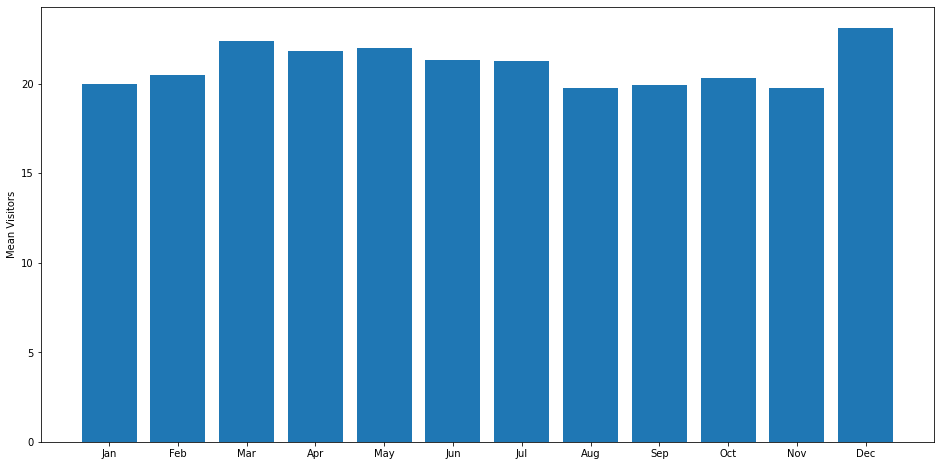

In [10]:
df = air_visit.copy()
df['month'] = air_visit['visit_date'].dt.month
df = df.groupby(['month']).mean()
month = [dt.date(1900, i, 1).strftime('%b') for i in range(1,13)]
plt.figure(figsize=(16,8))
plt.bar(month, df.visitors)
plt.ylabel('Mean Visitors')
plt.show()

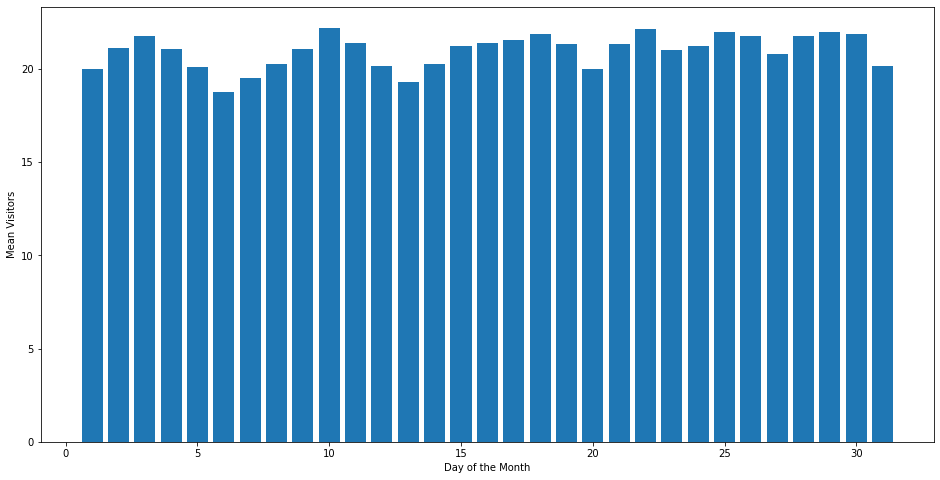

In [11]:
df = air_visit.copy()
df['day'] = air_visit['visit_date'].dt.day
df = df.groupby(['day']).mean()
plt.figure(figsize=(16,8))
plt.bar(list(df.index), df.visitors)
plt.ylabel('Mean Visitors')
plt.xlabel('Day of the Month')
plt.show()

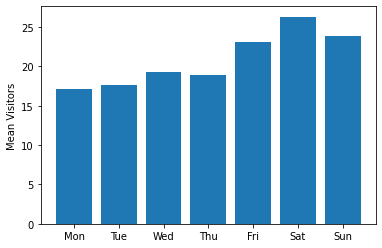

In [12]:
tmp_df = air_visit.copy()
tmp_df['dayofweek'] = tmp_df['visit_date'].dt.dayofweek
df = pd.merge(tmp_df, date_info, how='left', on=['visit_date'])
df = df.groupby(['dayofweek']).mean()
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], df.visitors)
plt.ylabel('Mean Visitors')
plt.show()

/Users/karthik/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


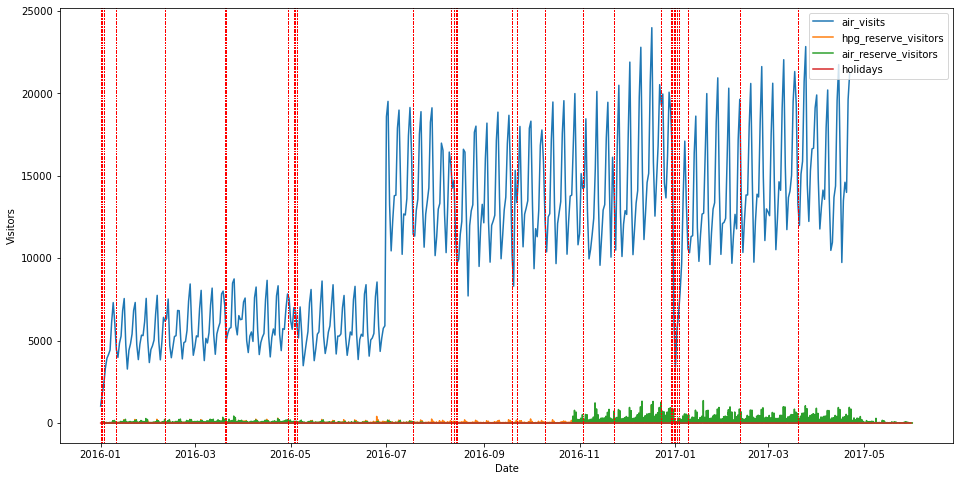

In [13]:
visitors = air_visit.groupby(['visit_date'], as_index=False).sum()
air_visitors = air_res.groupby(['visit_datetime'], as_index=False).sum()
hpg_air_res = pd.merge(hpg_res, store_id_rel, how='inner', on=['hpg_store_id'])
hpg_visitors = hpg_air_res.groupby(['visit_datetime'], as_index=False).sum()
hpg_visitors['visit_datetime'] = pd.to_datetime(hpg_visitors['visit_datetime'])
air_visitors['visit_datetime'] = pd.to_datetime(air_visitors['visit_datetime'])
df = pd.merge(air_visit, date_info, how='left', on=['visit_date'])
df[df.holiday_flg == 1]['visit_date']

plt.figure(figsize=(16,8))

plt.plot(visitors['visit_date'], visitors['visitors'])
plt.plot(hpg_visitors['visit_datetime'], hpg_visitors['reserve_visitors'])
plt.plot(air_visitors['visit_datetime'], air_visitors['reserve_visitors'])
plt.plot(date_info['visit_date'], date_info['holiday_flg'])

for i in df[df.holiday_flg == 1]['visit_date']:
    plt.axvline(x=i, linewidth=1, color='r', linestyle='dotted')
    
plt.gca().legend(('air_visits','hpg_reserve_visitors', 'air_reserve_visitors', 'holidays'))
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.rcParams['xtick.labelsize']=2
plt.rcParams['ytick.labelsize']=10
plt.show()

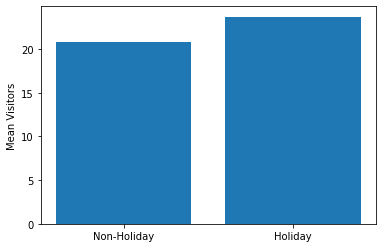

In [14]:
df = pd.merge(air_visit, date_info, how='left', on=['visit_date'])
df = df.groupby(['holiday_flg']).mean()
plt.rcParams['xtick.labelsize']=10
plt.bar(['Non-Holiday', 'Holiday'], df.visitors)
plt.ylabel('Mean Visitors')
plt.show()

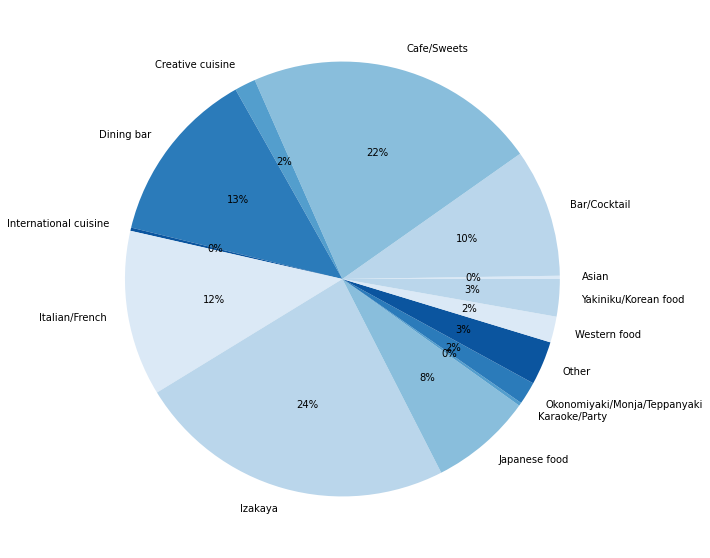

In [15]:
df = air_store.groupby(['air_genre_name'],as_index=False)['air_store_id'].count()
plt.figure(figsize=(20,10))
colors = sns.color_palette('Blues')
plt.pie(df.air_store_id, labels = df.air_genre_name, colors= colors, autopct='%.0f%%')
plt.show()

/Users/karthik/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


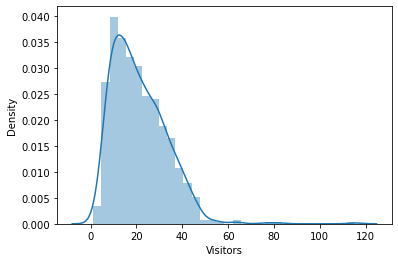

In [16]:
df = air_visit.groupby(['air_store_id'])['visitors'].mean().to_frame()
sns.distplot(df.visitors.values)
plt.xlabel('Visitors')
plt.show()

/Users/karthik/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/karthik/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


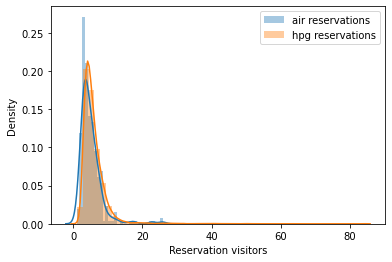

In [17]:
df1 = air_res.groupby(['air_store_id'])['reserve_visitors'].mean().to_frame()
df2 = hpg_res.groupby(['hpg_store_id'])['reserve_visitors'].mean().to_frame()
sns.distplot(df1.reserve_visitors.values, label='air reservations')
sns.distplot(df2.reserve_visitors.values,  label='hpg reservations')
plt.xlabel('Reservation visitors')
plt.legend()
plt.show()

### Prophet

In [18]:
train_data = air_visit.copy()
train_data = train_data.rename(columns={'visit_date': 'ds', 'visitors':'y'})

In [19]:
store_id = 'air_0f0cdeee6c9bf3d7'
air_visit_dates = train_data[train_data.air_store_id == store_id].drop(['air_store_id'], axis=1).reset_index().drop(['index'], axis=1)

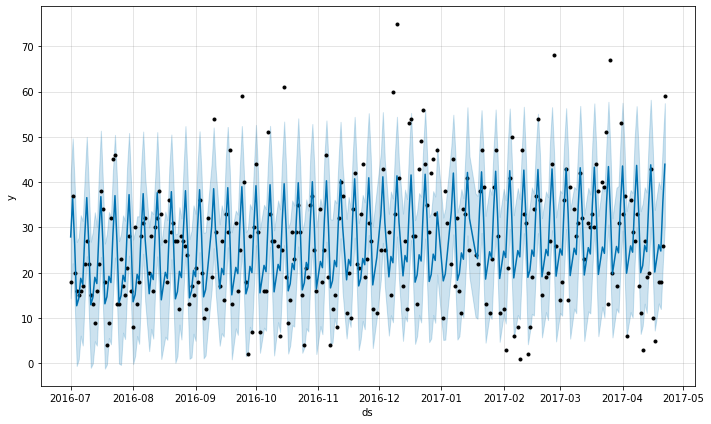

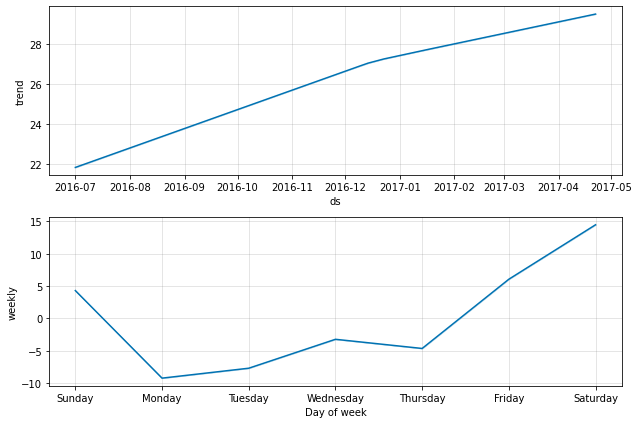

In [20]:
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False)
m.fit(air_visit_dates)
forecast = m.predict(air_visit_dates)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()

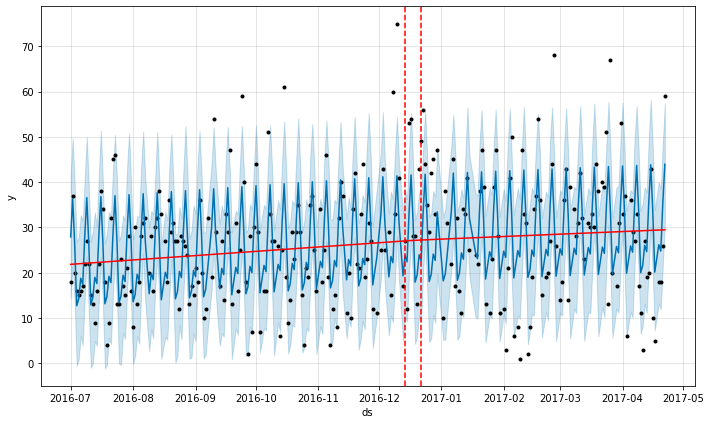

In [21]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [22]:
df_cv = cross_validation(m, initial=f'{len(air_visit_dates) - 30} days', period='10 days', horizon = '30 days')
df_cv['yhat'] = np.log1p(df_cv['yhat'])
df_cv['y'] = np.log1p(df_cv['y'])
performance_metrics(df_cv)

INFO:prophet:Making 3 forecasts with cutoffs between 2017-03-03 00:00:00 and 2017-03-23 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.447304,0.668808,0.555681,0.179050,0.148501,0.164949,0.0
1,4 days,0.335383,0.579123,0.450727,0.141784,0.058200,0.133457,0.0
2,5 days,0.153072,0.391244,0.331040,0.090000,0.072420,0.093432,0.0
3,6 days,0.080312,0.283393,0.246880,0.074895,0.067629,0.072833,0.0
4,7 days,0.113199,0.336451,0.294651,0.086794,0.067629,0.087042,0.0
5,8 days,0.100260,0.316639,0.268849,0.076207,0.044492,0.077702,0.0
6,9 days,0.094933,0.308112,0.264353,0.071866,0.044492,0.073893,0.0
7,10 days,0.080678,0.284039,0.233006,0.063926,0.030734,0.065635,0.0
8,11 days,0.293393,0.541657,0.387856,0.148292,0.086413,0.128270,0.0
9,12 days,0.477466,0.690989,0.503866,0.198284,0.086413,0.166082,0.0


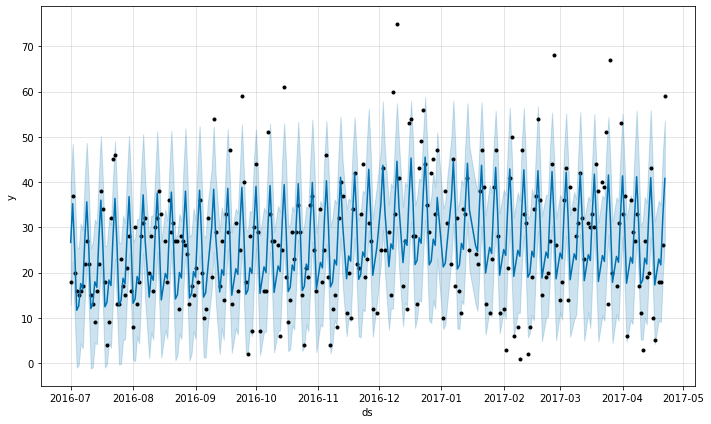

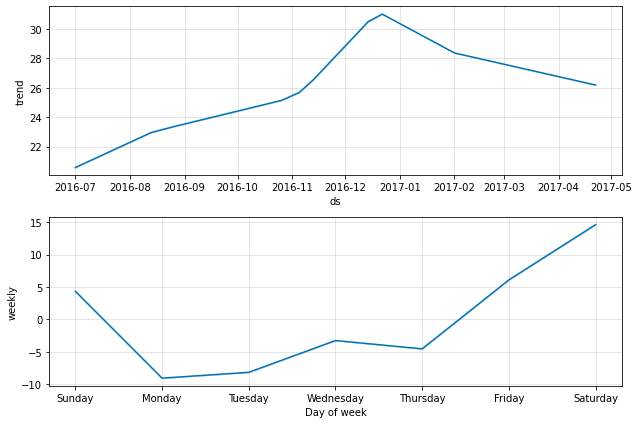

In [23]:
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False,
           changepoint_prior_scale=0.5,
            
          )
m.fit(air_visit_dates)
forecast = m.predict(air_visit_dates)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()

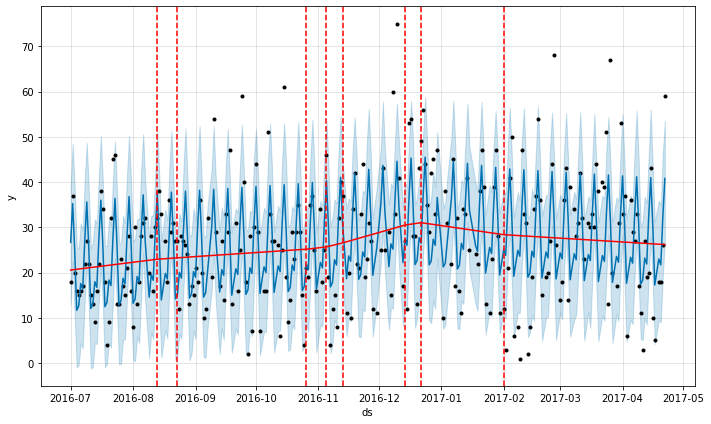

In [24]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [25]:
df_cv = cross_validation(m, initial=f'{len(air_visit_dates) - 30} days', period='10 days', horizon = '30 days')
df_cv['yhat'] = np.log1p(df_cv['yhat'])
df_cv['y'] = np.log1p(df_cv['y'])
performance_metrics(df_cv)

INFO:prophet:Making 3 forecasts with cutoffs between 2017-03-03 00:00:00 and 2017-03-23 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.499969,0.707085,0.609032,0.192388,0.138121,0.183666,0.142857
1,4 days,0.399020,0.631680,0.509185,0.157547,0.096910,0.153803,0.142857
2,5 days,0.253268,0.503258,0.420238,0.115460,0.097524,0.123737,0.142857
3,6 days,0.145653,0.381645,0.341451,0.102812,0.097524,0.103141,0.000000
4,7 days,0.188289,0.433923,0.370608,0.108678,0.097524,0.111946,0.000000
5,8 days,0.145287,0.381165,0.297941,0.084932,0.073624,0.088235,0.000000
6,9 days,0.131835,0.363091,0.286570,0.077959,0.039154,0.081530,0.000000
7,10 days,0.158617,0.398267,0.337081,0.094783,0.108964,0.099848,0.142857
8,11 days,0.413307,0.642889,0.514980,0.188396,0.113173,0.168789,0.142857
9,12 days,0.581766,0.762736,0.641630,0.240704,0.152170,0.211167,0.142857


In [26]:
# https://www.kaggle.com/huntermcgushion/rrv-weather-data?select=weather_stations.csv

def get_weather_data(data_df):
    weather_df = pd.read_csv('./data/Modified_weather.csv', index_col=0, parse_dates=[1], infer_datetime_format=True)
    weather_df = weather_df[['visit_date','station_id','avg_temperature','precipitation']]
    nearest_station = pd.read_csv('./data/weather/air_store_info_with_nearest_active_station.csv')
    store_ids = list(data_df['air_store_id'].unique())
    final_weather_df = pd.DataFrame()

    for id in store_ids:
        station = nearest_station[nearest_station.air_store_id == id].station_id.iloc[0]
        weather_data = weather_df[weather_df.station_id == station].drop(['station_id'], axis=1)
        merged = data_df[data_df.air_store_id == id].merge(weather_data, on='visit_date', how='left')
        final_weather_df = final_weather_df.append(merged, sort=False)
    return final_weather_df

mod_train_data = get_weather_data(air_visit)

Adding External Data

In [27]:
mod_air_visit_dates = mod_train_data[mod_train_data.air_store_id == store_id].drop(['air_store_id'], axis=1).rename(columns={"visit_date": "ds", "visitors": "y"})

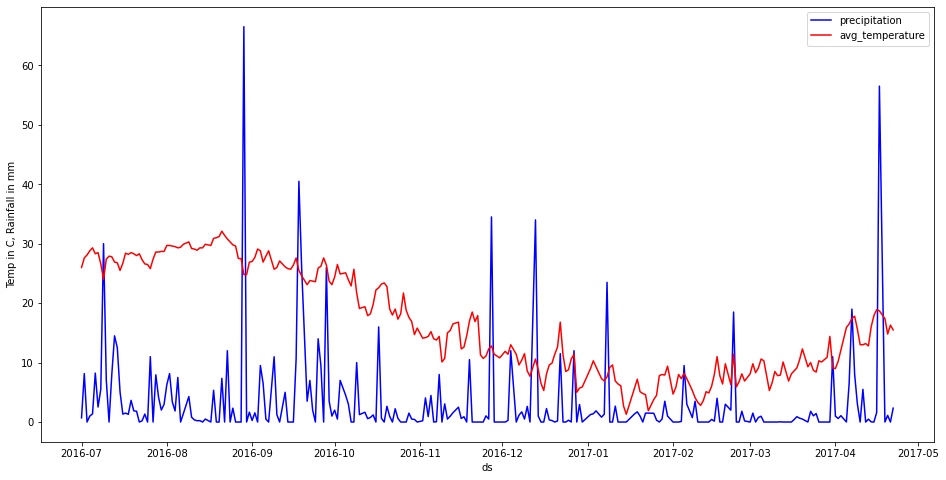

In [28]:
plt.figure(figsize=(16,8))
sns.lineplot(data=mod_air_visit_dates, x='ds', y="precipitation", color='b', label='precipitation')
sns.lineplot(data=mod_air_visit_dates, x='ds', y="avg_temperature", color='r', label='avg_temperature')

plt.ylabel('Temp in C, Rainfall in mm')
plt.show()

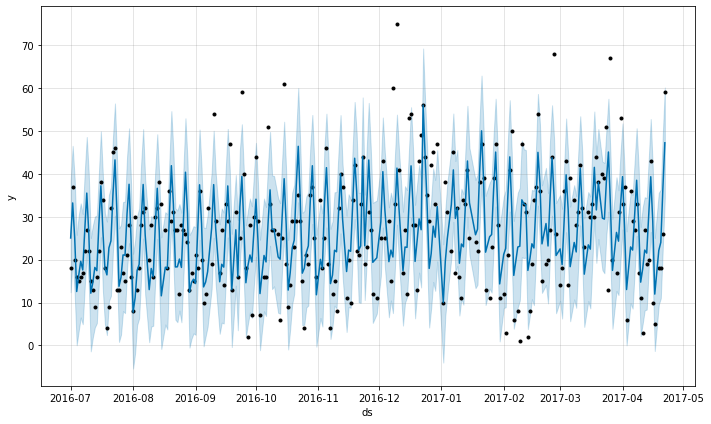

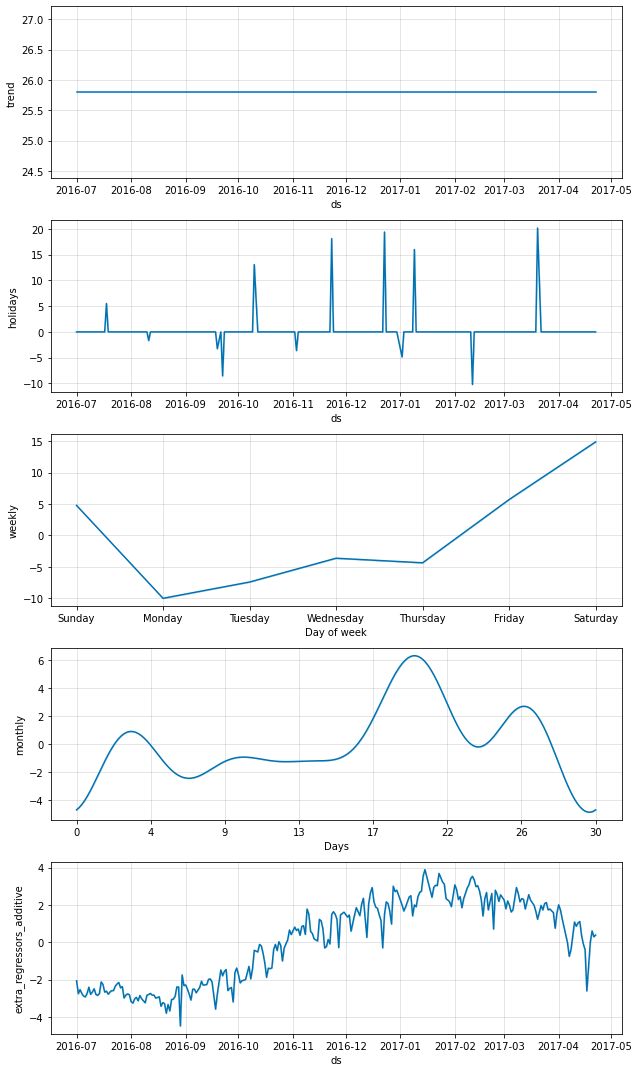

In [29]:
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.5,
            growth='flat',
           )
m.add_regressor('avg_temperature')
m.add_regressor('precipitation')
m.add_country_holidays(country_name='JP')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)


m.fit(mod_air_visit_dates)
forecast = m.predict(mod_air_visit_dates.drop(['y'], axis=1))
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()

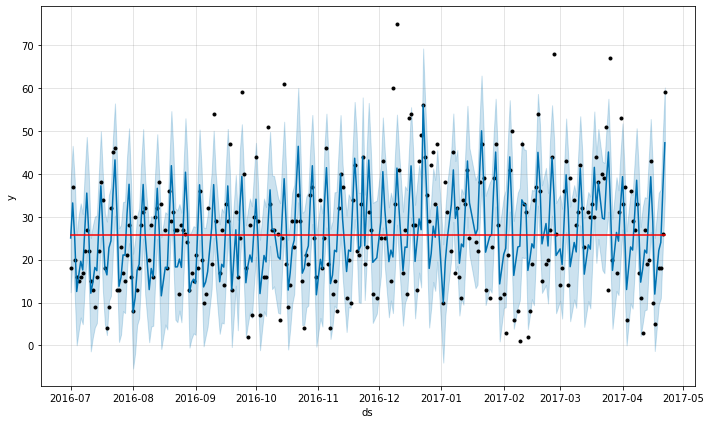

In [30]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [31]:
df_cv = cross_validation(m, initial=f'{len(air_visit_dates) - 30} days', period='10 days', horizon = '30 days')
df_cv['yhat'] = np.log1p(df_cv['yhat'])
df_cv['y'] = np.log1p(df_cv['y'])
performance_metrics(df_cv)

INFO:prophet:Making 3 forecasts with cutoffs between 2017-03-03 00:00:00 and 2017-03-23 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.493371,0.702404,0.612243,0.192142,0.177780,0.183680,0.000000
1,4 days,0.391206,0.625464,0.498062,0.152751,0.085506,0.149482,0.000000
2,5 days,0.242410,0.492351,0.400207,0.108291,0.105766,0.116027,0.000000
3,6 days,0.096349,0.310402,0.274183,0.081765,0.086711,0.082128,0.000000
4,7 days,0.150074,0.387394,0.343899,0.099862,0.086711,0.103170,0.000000
5,8 days,0.147803,0.384452,0.316325,0.088445,0.084155,0.092829,0.000000
6,9 days,0.110146,0.331882,0.247543,0.066496,0.047356,0.070368,0.000000
7,10 days,0.089793,0.299654,0.259935,0.072409,0.088307,0.075738,0.000000
8,11 days,0.155681,0.394565,0.346502,0.121218,0.088307,0.115683,0.142857
9,12 days,0.359511,0.599592,0.513151,0.185403,0.093130,0.168310,0.142857


In [356]:
tmp_df = test_data.copy().drop('visitors', axis=1)
tmp_df['visit_date'] = tmp_df['id'].map(lambda x: str(x).split('_')[2])
tmp_df['visit_date'] = pd.to_datetime(tmp_df['visit_date']).dt.date
tmp_df['air_store_id'] = tmp_df['id'].map(lambda x: '_'.join(x.split('_')[:2]))
tmp_df = tmp_df.drop(['id'], axis=1).rename(columns = {'visit_date': 'ds' ,'visitors': 'y'})

test_stores = tmp_df.air_store_id.unique()
submission = pd.DataFrame()

for cnt, store_id in enumerate(test_stores):

    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality=False,
                changepoint_prior_scale=0.5,
                growth='flat'
               )
#     m.add_regressor('avg_temperature')
#     m.add_regressor('precipitation')
    m.add_country_holidays(country_name='JP')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    print('Predicting %d of %d.'%(cnt + 1, len(test_stores)), end='\r')

    data = air_visit[air_visit['air_store_id'] == store_id].drop(['air_store_id'], axis=1)
    data.reset_index(drop=True, inplace=True)
    data = data.rename(columns = {'visit_date': 'ds' ,'visitors': 'y'})
    m.fit(data)
    future = tmp_df[tmp_df.air_store_id == store_id].drop('air_store_id', axis=1).reset_index(drop=True)
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']].rename(columns = {'ds': 'id' ,'yhat': 'visitors'})
    forecast['id'] = forecast['id'].apply(lambda x:'%s_%s'%(store_id, x.strftime('%Y-%m-%d')))
    submission = submission.append(forecast, ignore_index=True, sort=False)
    print('\nDone.')


Predicting 1 of 821.
Done.
Predicting 2 of 821.
Done.
Predicting 3 of 821.
Done.
Predicting 4 of 821.
Done.
Predicting 5 of 821.
Done.
Predicting 6 of 821.
Done.
Predicting 7 of 821.
Done.
Predicting 8 of 821.
Done.
Predicting 9 of 821.
Done.
Predicting 10 of 821.
Done.
Predicting 11 of 821.
Done.
Predicting 12 of 821.
Done.
Predicting 13 of 821.
Done.
Predicting 14 of 821.
Done.
Predicting 15 of 821.
Done.
Predicting 16 of 821.
Done.
Predicting 17 of 821.
Done.
Predicting 18 of 821.
Done.
Predicting 19 of 821.
Done.
Predicting 20 of 821.
Done.
Predicting 21 of 821.
Done.
Predicting 22 of 821.
Done.
Predicting 23 of 821.
Done.
Predicting 24 of 821.
Done.
Predicting 25 of 821.
Done.
Predicting 26 of 821.
Done.
Predicting 27 of 821.
Done.
Predicting 28 of 821.
Done.
Predicting 29 of 821.
Done.
Predicting 30 of 821.
Done.
Predicting 31 of 821.
Done.
Predicting 32 of 821.
Done.
Predicting 33 of 821.
Done.
Predicting 34 of 821.
Done.
Predicting 35 of 821.
Done.
Predicting 36 of 821.
Done.
P

INFO:prophet:n_changepoints greater than number of observations. Using 15.



Done.
Predicting 451 of 821.
Done.
Predicting 452 of 821.
Done.
Predicting 453 of 821.
Done.
Predicting 454 of 821.
Done.
Predicting 455 of 821.
Done.
Predicting 456 of 821.
Done.
Predicting 457 of 821.
Done.
Predicting 458 of 821.
Done.
Predicting 459 of 821.
Done.
Predicting 460 of 821.
Done.
Predicting 461 of 821.
Done.
Predicting 462 of 821.
Done.
Predicting 463 of 821.
Done.
Predicting 464 of 821.
Done.
Predicting 465 of 821.
Done.
Predicting 466 of 821.
Done.
Predicting 467 of 821.
Done.
Predicting 468 of 821.
Done.
Predicting 469 of 821.
Done.
Predicting 470 of 821.
Done.
Predicting 471 of 821.
Done.
Predicting 472 of 821.
Done.
Predicting 473 of 821.
Done.
Predicting 474 of 821.
Done.
Predicting 475 of 821.
Done.
Predicting 476 of 821.
Done.
Predicting 477 of 821.
Done.
Predicting 478 of 821.
Done.
Predicting 479 of 821.
Done.
Predicting 480 of 821.
Done.
Predicting 481 of 821.
Done.
Predicting 482 of 821.
Done.
Predicting 483 of 821.
Done.
Predicting 484 of 821.
Done.
Predict

In [32]:
submission.to_csv('./submit_pro.csv', index=False)

### Regression Approach

In [33]:
air_visit = pd.read_csv('./data/air_visit_data.csv', parse_dates=[1], infer_datetime_format=True)
air_res = pd.read_csv('./data/air_reserve.csv', parse_dates=[1 , 2], infer_datetime_format=True)
air_store = pd.read_csv('./data/air_store_info.csv')
hpg_res = pd.read_csv('./data/hpg_reserve.csv', parse_dates=[1 , 2], infer_datetime_format=True)
hpg_store = pd.read_csv('./data/hpg_store_info.csv')
store_id_rel = pd.read_csv('./data/store_id_relation.csv')
date_info = pd.read_csv('./data/date_info.csv', parse_dates=[0], infer_datetime_format=True).rename(columns={'calendar_date': 'visit_date'})
sub_data = pd.read_csv('./data/sample_submission.csv')

#### Data merging and Feature engineering

1. splitting visit_date into month, day of week and day

In [34]:
train_data = air_visit.copy()
train_data['is_test'] = 'False'

tmp_df = sub_data.copy()
tmp_df['visit_date'] = tmp_df['id'].map(lambda x: str(x).split('_')[2])
tmp_df['visit_date'] = pd.to_datetime(tmp_df['visit_date'])
tmp_df['air_store_id'] = tmp_df['id'].map(lambda x: '_'.join(x.split('_')[:2]))
tmp_df['is_test'] = 'True'
tmp_df.drop(['id'], axis=1, inplace=True)

train_data = train_data.append(tmp_df)
train_data = train_data.reset_index(drop=True)

train_data['month'] = train_data['visit_date'].dt.month
train_data['dayofweek'] = train_data['visit_date'].dt.dayofweek
train_data['day'] = train_data['visit_date'].dt.day

train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18


2. merging date_info and adding pre-holiday and post holiday flags

In [35]:
tmp_data_info = date_info.rename(columns={'holiday_flg': 'holiday'})
tmp_data_info['prev_day_holiday'] = tmp_data_info['holiday'].shift().fillna(0)
tmp_data_info['next_day_holiday'] = tmp_data_info['holiday'].shift(-1).fillna(0)

train_data = pd.merge(train_data, tmp_data_info.drop(['day_of_week'], axis=1), how='left', on="visit_date")

train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day,holiday,prev_day_holiday,next_day_holiday
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13,0,0.0,0.0
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14,0,0.0,0.0
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15,0,0.0,0.0
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16,0,0.0,0.0
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18,0,0.0,0.0


3. merging air_store

In [36]:
train_data = pd.merge(train_data, air_store, how='left', on="air_store_id")

encoder = LabelEncoder()
train_data['air_genre_name'] = encoder.fit_transform(train_data['air_genre_name'])
train_data['air_area_name'] = encoder.fit_transform(train_data['air_area_name'])
train_data['rel_lat'] = train_data['latitude'].max() - train_data['latitude']
train_data['rel_long'] = train_data['longitude'].max() - train_data['longitude']
train_data.drop(['latitude', 'longitude'], axis=1, inplace=True)

train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day,holiday,prev_day_holiday,next_day_holiday,air_genre_name,air_area_name,rel_lat,rel_long
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13,0,0.0,0.0,4,62,8.362564,4.521799
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14,0,0.0,0.0,4,62,8.362564,4.521799
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15,0,0.0,0.0,4,62,8.362564,4.521799
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16,0,0.0,0.0,4,62,8.362564,4.521799
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18,0,0.0,0.0,4,62,8.362564,4.521799


4. merge weather data

In [37]:
# weather data source:
# https://www.kaggle.com/huntermcgushion/rrv-weather-data?select=weather_stations.csv

weather_df = pd.read_csv('./data/Modified_weather.csv', index_col=0, parse_dates=[1], infer_datetime_format=True)
weather_df = weather_df[['visit_date','station_id','avg_temperature','precipitation']]
nearest_stations = pd.read_csv('./data/weather/air_store_info_with_nearest_active_station.csv')

def get_weather_data(weather_df, nearest_stations, data_df):
    store_ids = list(data_df['air_store_id'].unique())
    final_weather_df = pd.DataFrame()
    for id in store_ids:
        station = nearest_stations[nearest_stations.air_store_id == id].station_id.iloc[0]
        weather_data = weather_df[weather_df.station_id == station].drop(['station_id'], axis=1)
        merged = data_df[data_df.air_store_id == id].merge(weather_data, on='visit_date', how='left')
        final_weather_df = final_weather_df.append(merged, sort=False)
    return final_weather_df

train_data = get_weather_data(weather_df, nearest_stations, train_data)
train_data = train_data.merge(nearest_stations[['air_store_id', 'station_vincenty']], on='air_store_id', how='left')

train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day,holiday,prev_day_holiday,next_day_holiday,air_genre_name,air_area_name,rel_lat,rel_long,avg_temperature,precipitation,station_vincenty
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13,0,0.0,0.0,4,62,8.362564,4.521799,4.3,1.893173,3.730672
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14,0,0.0,0.0,4,62,8.362564,4.521799,6.0,2.988782,3.730672
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15,0,0.0,0.0,4,62,8.362564,4.521799,5.6,0.000000,3.730672
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16,0,0.0,0.0,4,62,8.362564,4.521799,6.5,1.536066,3.730672
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18,0,0.0,0.0,4,62,8.362564,4.521799,2.8,67.000000,3.730672


5. merging reservation data

In [38]:
hpg_air_res = pd.merge(hpg_res, store_id_rel, how='inner', on=['hpg_store_id'])
hpg_air_res.drop("hpg_store_id", axis=1, inplace=True)

res_data = pd.concat([air_res, hpg_air_res])
res_data['visit_datetime'] = res_data['visit_datetime'].dt.date
res_data['reserve_datetime'] = res_data['reserve_datetime'].dt.date

res_data['res_diff'] = res_data.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
df1 = res_data.groupby(['air_store_id', 'visit_datetime'], as_index=False)[
    ['res_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime': 'visit_date', 'res_diff': 'air_rd_sum', 'reserve_visitors':'air_rv_sum'})
df2 = res_data.groupby(['air_store_id', 'visit_datetime'], as_index=False)[
    ['res_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime': 'visit_date', 'res_diff': 'air_rd_mean', 'reserve_visitors':'air_rv_mean'})
res_data = pd.merge(df1, df2, how='inner', on=['air_store_id','visit_date'])

train_data['visit_date'] = train_data['visit_date'].dt.date
train_data = pd.merge(train_data, res_data, how='left', on=['air_store_id','visit_date'])

train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day,holiday,prev_day_holiday,next_day_holiday,...,air_area_name,rel_lat,rel_long,avg_temperature,precipitation,station_vincenty,air_rd_sum,air_rv_sum,air_rd_mean,air_rv_mean
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13,0,0.0,0.0,...,62,8.362564,4.521799,4.3,1.893173,3.730672,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14,0,0.0,0.0,...,62,8.362564,4.521799,6.0,2.988782,3.730672,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15,0,0.0,0.0,...,62,8.362564,4.521799,5.6,0.000000,3.730672,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16,0,0.0,0.0,...,62,8.362564,4.521799,6.5,1.536066,3.730672,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18,0,0.0,0.0,...,62,8.362564,4.521799,2.8,67.000000,3.730672,NaN,NaN,NaN,NaN


6. fill weekly, monthly and store by stats as additional features

In [39]:
stats = ['mean', 'min', 'max', 'median', 'count', 'std', 'var', 'skew']
for stat in stats:
    df = getattr(train_data.groupby(['air_store_id', 'dayofweek'], as_index=False, sort=False)['visitors'], stat)().rename(columns={'visitors': f'dow_{stat}_visitors'})
    train_data = pd.merge(train_data, df, how='left', on=['air_store_id', 'dayofweek'])

    df = getattr(train_data.groupby(['air_store_id', 'month'], as_index=False, sort=False)['visitors'], stat)().rename(columns={'visitors': f'monthly_{stat}_visitors'})
    train_data = pd.merge(train_data, df, how='left', on=['air_store_id', 'month'])
    
    df = getattr(train_data.groupby(['air_store_id'], as_index=False, sort=False)['visitors'], stat)().rename(columns={'visitors': f'{stat}_visitors_bystore'})
    train_data = pd.merge(train_data, df, how='left', on=['air_store_id'])

train_data.fillna(0, inplace=True) 
train_data.head()

,air_store_id,visit_date,visitors,is_test,month,dayofweek,day,holiday,prev_day_holiday,next_day_holiday,...,count_visitors_bystore,dow_std_visitors,monthly_std_visitors,std_visitors_bystore,dow_var_visitors,monthly_var_visitors,var_visitors_bystore,dow_skew_visitors,monthly_skew_visitors,skew_visitors_bystore
0,air_ba937bf13d40fb24,2016-01-13,25,False,1,2,13,0,0.0,0.0,...,430,11.138912,9.461257,13.02744,124.075362,89.515385,169.714187,0.045006,0.010728,0.339452
1,air_ba937bf13d40fb24,2016-01-14,32,False,1,3,14,0,0.0,0.0,...,430,10.626240,9.461257,13.02744,112.916977,89.515385,169.714187,0.524483,0.010728,0.339452
2,air_ba937bf13d40fb24,2016-01-15,29,False,1,4,15,0,0.0,0.0,...,430,13.812078,9.461257,13.02744,190.773499,89.515385,169.714187,-0.655874,0.010728,0.339452
3,air_ba937bf13d40fb24,2016-01-16,22,False,1,5,16,0,0.0,0.0,...,430,12.721629,9.461257,13.02744,161.839839,89.515385,169.714187,-0.187496,0.010728,0.339452
4,air_ba937bf13d40fb24,2016-01-18,6,False,1,0,18,0,0.0,0.0,...,430,8.083791,9.461257,13.02744,65.347670,89.515385,169.714187,0.480270,0.010728,0.339452


In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 45 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   air_store_id             284127 non-null  object 
 1   visit_date               284127 non-null  object 
 2   visitors                 284127 non-null  int64  
 3   is_test                  284127 non-null  object 
 4   month                    284127 non-null  int64  
 5   dayofweek                284127 non-null  int64  
 6   day                      284127 non-null  int64  
 7   holiday                  284127 non-null  int64  
 8   prev_day_holiday         284127 non-null  float64
 9   next_day_holiday         284127 non-null  float64
 10  air_genre_name           284127 non-null  int64  
 11  air_area_name            284127 non-null  int64  
 12  rel_lat                  284127 non-null  float64
 13  rel_long                 284127 non-null  float64
 14  avg_

In [41]:
train_data = pd.get_dummies(train_data, columns=['dayofweek', 'month'])
columns = [c for c in train_data if c not in ['air_store_id', 'visit_date', 'visitors','is_test']]

td = train_data[train_data.is_test == 'False'].reset_index(drop=True)
X = td[columns]
y = td['visitors'].apply(np.log1p).values

test_data = train_data[train_data.is_test == 'True'].reset_index(drop=True)
X_test = test_data[columns]

np.random.seed(42)
def rmsle(y, yhat):
    return metrics.mean_squared_error(y, yhat) ** 0.5

#### 1. AdaBoost

##### Hyper Parameter Tuning

In [ ]:
search_parameters = {
            'n_estimators': [5, 10, 50, 100, 250, 500, 1000],
            'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

ada_regressor = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=10), 
    random_state=42
)

scorer = metrics.make_scorer(score_func=rmsle, greater_is_better=False)
ada_param_search = GridSearchCV(
                    estimator=ada_regressor,
                    param_grid=search_parameters,
                    scoring=scorer,
                    return_train_score=True,
                    cv=2,
                    n_jobs= -1)
ada_param_search.fit(X=X, y=y)
ada_param_search.best_params_

In [ ]:
ada_regressor = AdaBoostRegressor(
            base_estimator=DecisionTreeRegressor(max_depth=10),
            learning_rate=0.01, 
            n_estimators=100,
            random_state=42)

K = 3
folds = KFold(n_splits = K, random_state = 42, shuffle = True)


yhat_test = 0
for i, (train_index, valid_index) in enumerate(folds.split(td)):
    y_train, y_valid = y[train_index].copy(), y[valid_index]
    X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[valid_index, :].copy()

    ada_regressor.fit(X_train, y_train)
    yhat_valid = ada_regressor.predict(X_valid)
    
    print(f'RMSLE for fold {i}: {rmsle(y_valid, yhat_valid)}')

    yhat_test += ada_regressor.predict(X_test)

yhat_test /= K 

test_data['visitors'] = np.expm1(yhat_test) 

tmp_df = sub_data.copy().drop('visitors', axis=1)
tmp_df['visit_date'] = tmp_df['id'].map(lambda x: str(x).split('_')[2])
tmp_df['visit_date'] = pd.to_datetime(tmp_df['visit_date']).dt.date
tmp_df['air_store_id'] = tmp_df['id'].map(lambda x: '_'.join(x.split('_')[:2]))

submission = pd.merge(tmp_df, test_data, on=['visit_date','air_store_id'], how='inner')[['id','visitors']]

submission.to_csv('submit_ada.csv', index=False)

#### 2. XGBoost

##### Hyper Parameter Tuning

In [ ]:
search_parameters = {
                'learning_rate':[0.2, 0.1, 0.01, 0.001],
                'min_child_weight':[0.7, 0.8, 0.9, 1],
              'subsample':[0.5, 0.6, 0.7, 0.8],
              'colsample_bytree':[0.3, 0.4, 0.5, 0.6],
              'max_depth': [2, 4, 8, 12]}

xgb_regressor = xgb.XGBRegressor(tree_method='gpu_hist')

scorer = metrics.make_scorer(score_func=rmsle, greater_is_better=False)
xgb_param_search = GridSearchCV(
                     estimator=xgb_regressor,
                     param_grid=search_parameters,
                    scoring=scorer,
                     cv=2,
                     return_train_score=True,
                     n_jobs=-1,
                     )
xgb_param_search.fit(X=X, y=y)

xgb_param_search.best_params_

In [ ]:
K = 3
folds = KFold(n_splits = K, random_state = 42, shuffle = True)
yhat_test = 0

parameters = {'objective':'reg:squarederror',
              'eval_metric':'rmse',
              'learning_rate':0.01, 
              'min_child_weight':0.8,
              'subsample':0.6,
              'colsample_bytree':0.8,
              'max_depth': 8, 
              'tree_method':'gpu_hist'}

test_matrix = xgb.DMatrix(data=X_test)
for i, (train_index, valid_index) in enumerate(folds.split(td)):
    y_train, y_valid = y[train_index].copy(), y[valid_index]
    X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[valid_index, :].copy()
    
    train_matrix = xgb.DMatrix(data=X_train, label=y_train)
    valid_matrix = xgb.DMatrix(data=X_valid, label=y_valid)

    xgb_regressor = xgb.train(
                     params=parameters,
                     dtrain=train_matrix,
                     evals=[(train_matrix,'train'),(valid_matrix, 'test')],
                     num_boost_round =1100)

    yhat_test += xgb_regressor.predict(test_matrix)

yhat_test /= K 

test_data['visitors'] = np.expm1(yhat_test)

tmp_df = sub_data.copy().drop('visitors', axis=1)
tmp_df['visit_date'] = tmp_df['id'].map(lambda x: str(x).split('_')[2])
tmp_df['visit_date'] = pd.to_datetime(tmp_df['visit_date']).dt.date
tmp_df['air_store_id'] = tmp_df['id'].map(lambda x: '_'.join(x.split('_')[:2]))

submission = pd.merge(tmp_df, test_data, on=['visit_date','air_store_id'], how='inner')[['id','visitors']]
submission.to_csv('submit_xgb.csv', index=False)